In [39]:
### 
import pandas as pd
import random
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm  
import seaborn as sns
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Flatten, Permute, LSTM, Conv1D, Dropout, Bidirectional, Multiply, \
    Concatenate, Multiply, Lambda, RepeatVector, Activation
from tensorflow.keras.models import Model, Sequential
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = 'songti sc'

In [40]:
data = pd.read_csv("./speed.csv", index_col=0)
data.index = pd.to_datetime(data.index)
# data.index = range(len(data))
data.head()

,车流量,温度,湿度,气压,道路拥堵指数,车速(m/s)
时间,,,,,,
2023-03-01 00:00:00,3119,6.635445,41.991183,101.304484,0.618239,22
2023-03-01 00:15:00,1599,24.484669,54.049135,101.692347,0.390966,21
2023-03-01 00:30:00,1669,23.021680,58.524927,101.720204,0.453731,21
2023-03-01 00:45:00,2653,13.656662,43.941204,101.201497,0.438441,22
2023-03-01 01:00:00,2826,11.674758,36.631670,100.977894,0.448393,23


In [3]:
# 获取每隔30分钟的数据
# 将数据按照每隔30分钟进行汇总，并取每个时间段内的平均值
df_resample = data.resample('30T').mean()
df_resample.index = range(len(df_resample))
df_resample.head()

,车流量,温度,湿度,气压,道路拥堵指数,车速(m/s)
0,2359.0,15.560057,48.020159,101.498416,0.504603,21.5
1,2161.0,18.339171,51.233066,101.460851,0.446086,21.5
2,3030.5,16.435976,42.739429,101.147260,0.581503,24.0
3,2325.0,16.648018,46.410436,101.182484,0.492695,28.0
4,2484.0,9.863020,62.262554,101.284574,0.360523,29.0


## 数据分析

In [4]:
# 数据维度
df = df_resample.copy()
print(df.shape)

(3601, 6)


In [5]:
# 数据字段类型
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   车流量      3601 non-null   float64
 1   温度       3601 non-null   float64
 2   湿度       3601 non-null   float64
 3   气压       3601 non-null   float64
 4   道路拥堵指数   3601 non-null   float64
 5   车速(m/s)  3601 non-null   float64
dtypes: float64(6)
memory usage: 168.9 KB
None


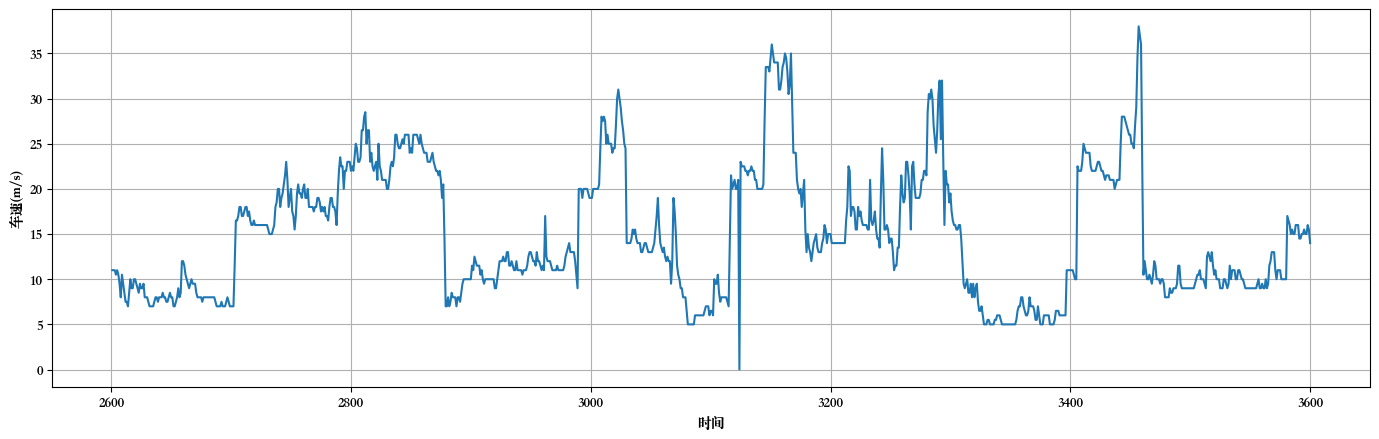

In [6]:
# 车速的时间序列走势
plt.figure(figsize=(17,5), dpi=100)
plt.plot(df.index[-1000:], df['车速(m/s)'][-1000:])
plt.grid()
plt.xlabel("时间")
plt.ylabel("车速(m/s)")
plt.show()

<Figure size 432x288 with 0 Axes>

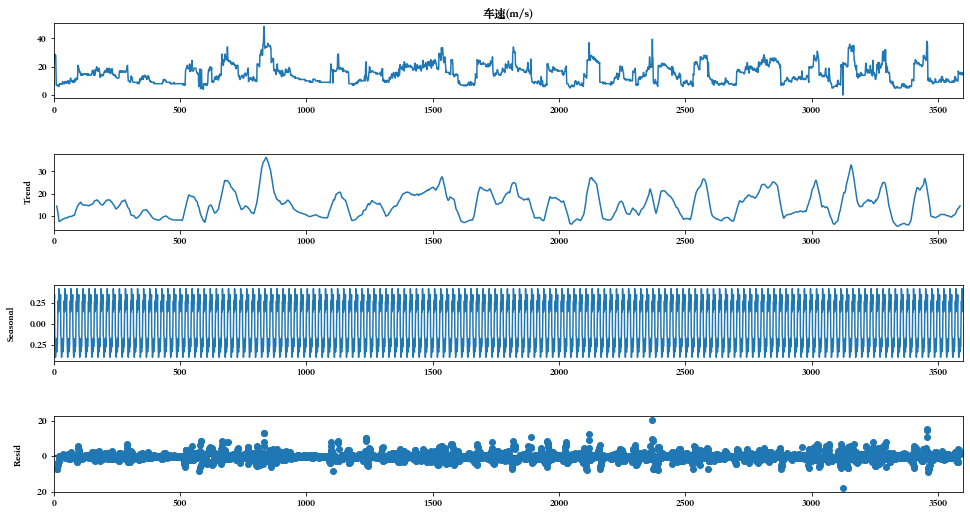

In [7]:
# 可见数据存在一定的时间周期
# 进一步的分析时间的周期性、季节趋势等
decomposition = seasonal_decompose(df['车速(m/s)'], period=24) 
# 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
plt.show()

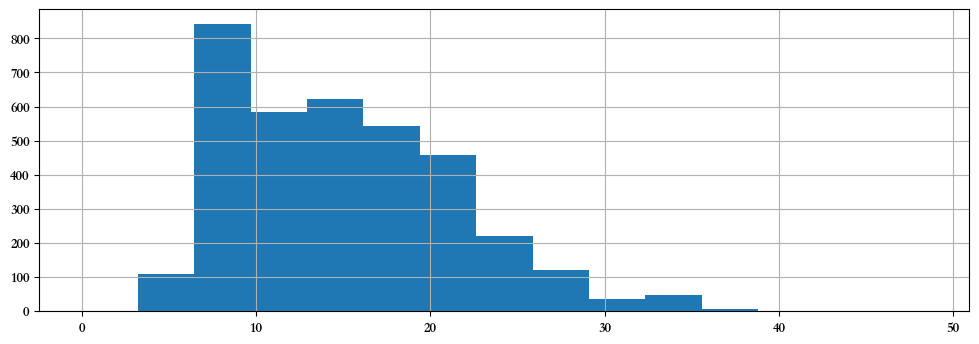

In [8]:
#车速(m/s)的直方图分布\
plt.figure(figsize=(12,4), dpi=100)
plt.hist(df['车速(m/s)'], bins=15)
plt.grid()
plt.show() # 分布比较均衡,大多30和40左右

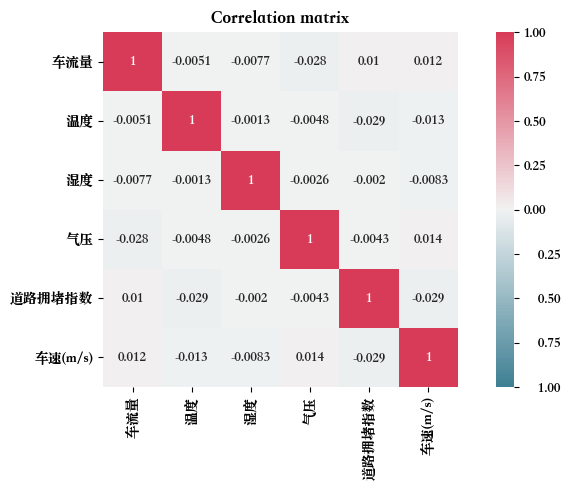

In [9]:
fig, ax=plt.subplots(figsize=(8,5), dpi=100)
cmap = sns.diverging_palette(220, 6, as_cmap=True)
sns.heatmap(df.corr(), vmax=1, vmin=-1, center=0, square=True, ax=ax, cmap=cmap, annot=True)
ax.set_title('Correlation matrix', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

In [10]:
# 和各个变量之间的相关性不高

## 数据预处理

In [11]:
# 数据归一化
# 时间序列对数据量纲是十分敏感的，所以必须进行数据归一化
from sklearn.preprocessing import MinMaxScaler, StandardScaler
dataset = df['车速(m/s)'].values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1, 1)
scaler = MinMaxScaler()
sc_model = scaler.fit(dataset)
dataset= sc_model.transform(dataset)

In [12]:
# 训练和测试的划分
# 7:3的比例分为训练集和测试集
train_size = int(len(dataset) * 0.7)  ##前70%作为训练，30%作为测试
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

2520 1081


## LSTM模型

In [13]:
def creat_dataset(data, lagTerm=1):
    # 创建数据集以供LSTM使用，转换为LSTM所需要的数据格式
    # lagTerm: 滑动窗口大小，认为前lagTerm条数据将会影响lagTerm+1的数据
    dataX, dataY = [],[]
    for i in range(len(data) - lagTerm):
        cache = data[i:(i+lagTerm),0]
        dataX.append(cache)
        dataY.append(data[i+lagTerm,0])
    return np.array(dataX), np.array(dataY)
look_back = 10
trainX,trainY = creat_dataset(train, look_back)
testX, testY = creat_dataset(test, look_back)

In [14]:
#训练和测试的数据维度转换 [samples, time_steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape)

(2510, 1, 10) (2510,)


采用mse作为损失函数，采用Adam梯度优化算法，学习率为0.001。在模型训练过程中，我们设置了100个epoch，并使用早停法（Early Stopping）避免过拟合。模型的训练过程中采用了批量训练（Batch Training）

In [15]:
from tensorflow.keras.optimizers import Adam
def lstm_model(numEpoch,batchSize,X,y,callBack):
    model = Sequential()
    model.add(LSTM(
        120,
        input_shape=(X.shape[1], X.shape[2]),
        return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(
        128,
        return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation("relu"))
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mae', metrics=['mse'])
    history = model.fit(X,y,epochs = numEpoch, batch_size=32, verbose=1, validation_split=0.25, callbacks=callBack)
    return model,history

In [16]:
import keras
# Early stop callback function.

early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
# 保存模型
model_save = keras.callbacks.ModelCheckpoint(filepath="lstm_30min.h5", save_weights_only=False, monitor='val_loss',
                                 save_best_only=True)
lstm, lstm_history = lstm_model(100, 32, trainX, trainY, [model_save])

Using TensorFlow backend.
2023-12-21 22:42:14.510857: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-21 22:42:14.525362: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 22:42:18.454688: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
59/59 [==============================] - 17s 108ms/step - loss: 0.1391 - mse: 0.0362 - val_loss: 0.0459 - val_mse: 0.0042
Epoch 2/100
59/59 [==============================] - 1s 9ms/step - loss: 0.0462 - mse: 0.0045 - val_loss: 0.0320 - val_mse: 0.0026
Epoch 3/100
59/59 [==============================] - 1s 9ms/step - loss: 0.0416 - mse: 0.0039 - val_loss: 0.0274 - val_mse: 0.0021
Epoch 4/100
59/59 [==============================] - 1s 9ms/step - loss: 0.0398 - mse: 0.0033 - val_loss: 0.0345 - val_mse: 0.0025
Epoch 5/100
59/59 [==============================] - 1s 9ms/step - loss: 0.0351 - mse: 0.0027 - val_loss: 0.0303 - val_mse: 0.0021
Epoch 6/100
59/59 [==============================] - 1s 9ms/step - loss: 0.0343 - mse: 0.0026 - val_loss: 0.0257 - val_mse: 0.0018
Epoch 7/100
59/59 [==============================] - 1s 9ms/step - loss: 0.0312 - mse: 0.0023 - val_loss: 0.0217 - val_mse: 0.0015
Epoch 8/100
59/59 [==============================] - 1s 10ms/step - loss: 0.0304

Epoch 63/100
59/59 [==============================] - 1s 9ms/step - loss: 0.0269 - mse: 0.0018 - val_loss: 0.0222 - val_mse: 0.0014
Epoch 64/100
59/59 [==============================] - 1s 10ms/step - loss: 0.0287 - mse: 0.0019 - val_loss: 0.0218 - val_mse: 0.0014
Epoch 65/100
59/59 [==============================] - 1s 11ms/step - loss: 0.0282 - mse: 0.0021 - val_loss: 0.0197 - val_mse: 0.0013
Epoch 66/100
59/59 [==============================] - 1s 11ms/step - loss: 0.0277 - mse: 0.0018 - val_loss: 0.0221 - val_mse: 0.0014
Epoch 67/100
59/59 [==============================] - 1s 10ms/step - loss: 0.0285 - mse: 0.0023 - val_loss: 0.0284 - val_mse: 0.0022
Epoch 68/100
59/59 [==============================] - 1s 11ms/step - loss: 0.0334 - mse: 0.0032 - val_loss: 0.0218 - val_mse: 0.0014
Epoch 69/100
59/59 [==============================] - 1s 9ms/step - loss: 0.0280 - mse: 0.0019 - val_loss: 0.0228 - val_mse: 0.0015
Epoch 70/100
59/59 [==============================] - 1s 9ms/step - los

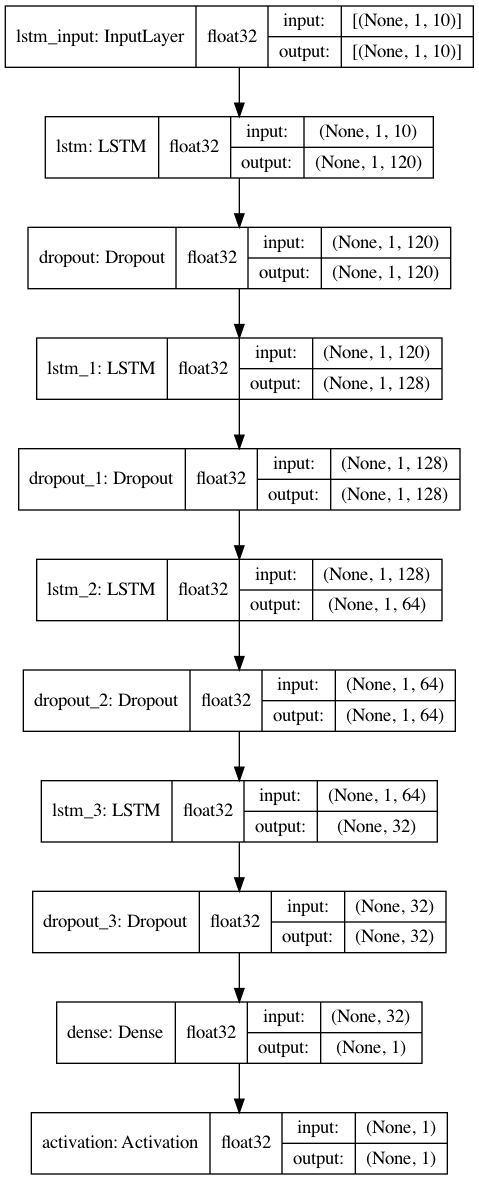

In [17]:
plot_model(lstm, "lstm.png", show_dtype=True, 
          show_layer_names=True, show_shapes = True)

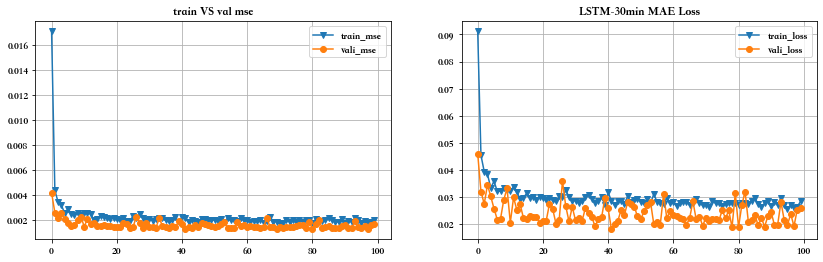

In [18]:
train_loss=lstm_history.history['loss']
vali_loss=lstm_history.history['val_loss']
train_acc = lstm_history.history['mse']
vali_acc = lstm_history.history['val_mse']
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(range(len(train_acc)),train_acc,marker='v',label='train_mse')
plt.plot(range(len(train_acc)),vali_acc,marker='o',label='vali_mse')
plt.legend()
plt.title("LSTM-30min MSE")
plt.grid()
plt.title("train VS val mse")
plt.subplot(1,2,2)
plt.plot(range(len(train_loss)),train_loss,marker='v',label='train_loss')
plt.plot(range(len(train_loss)),vali_loss,marker='o',label='vali_loss')
plt.legend()
plt.title("train VS val loss")
plt.grid()
plt.title("LSTM-30min MAE Loss")
plt.show()

In [19]:
# LSTM模型在测试上的效果--MSE和MAE以及MAPE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import load_model
lstm_best = load_model("lstm_30min.h5")
lstm_pred = lstm_best.predict(testX)
inverse_lstm_pred = sc_model.inverse_transform(lstm_pred)

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
inverse_test = sc_model.inverse_transform(testY.reshape(-1,1))
lstm_rmse = np.sqrt(mean_squared_error(inverse_test, inverse_lstm_pred))
lstm_mae = mean_absolute_error(inverse_test, inverse_lstm_pred)

# 均方根误差、平均绝对误差
print("LSTM 30min MAE:", lstm_mae)
print("LSTM 30min RMSE:", lstm_rmse)

LSTM 30min MAE: 1.0496665
LSTM 30min RMSE: 1.9367249


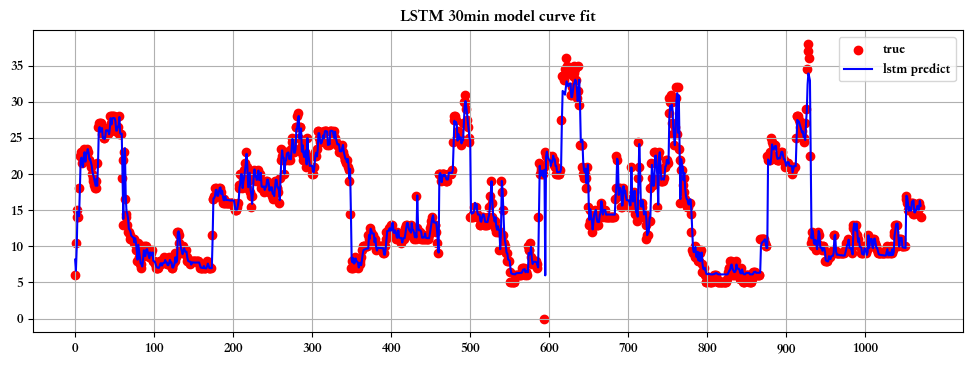

In [21]:

indexs = range(len(df.index[-testX.shape[0]:]))
# 拟合情况
plt.figure(figsize = (12,4), dpi=100)
plt.scatter(indexs, inverse_test, marker='o', label='true', c='red')
plt.plot(indexs, inverse_lstm_pred, c='blue', label='lstm predict')
plt.legend()
plt.title("LSTM 30min model curve fit")
plt.grid()
plt.xticks(np.arange(0, len(df.index[-testX.shape[0]:]), 100))
plt.show() # 可见拟合得很好

## ARIMA

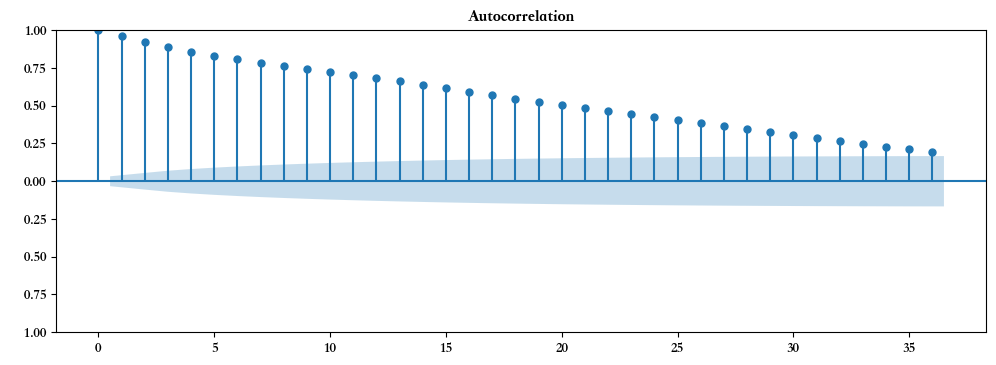

In [22]:
series = np.array(df['车速(m/s)'].values)
from statsmodels.graphics.tsaplots import plot_acf
fig = plt.figure(figsize=(12,4), dpi=100)
ax1=fig.add_subplot(111)
plot_acf(series,ax=ax1).show()###自相关图检验平稳性

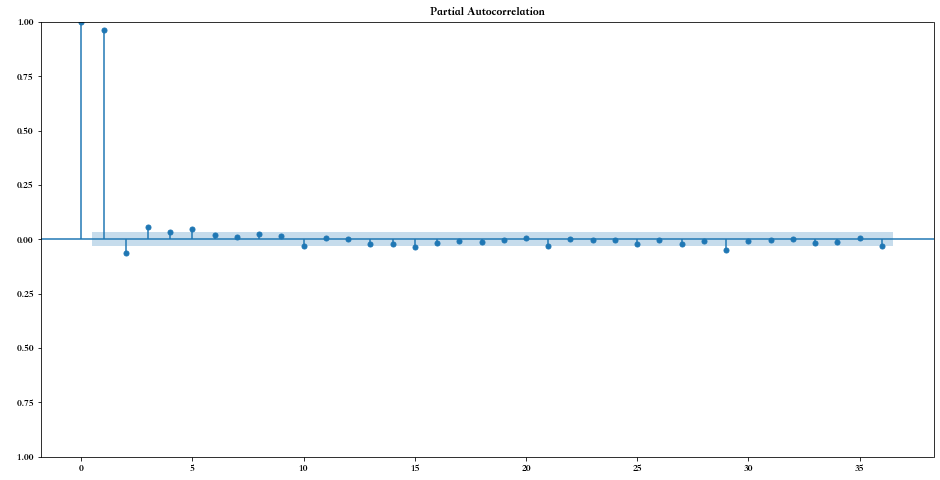

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf###偏自相关图
fig = plt.figure(figsize=(16,8))
ax2=fig.add_subplot(111)
plot_pacf(series,ax=ax2).show()

In [24]:
# 平稳性检测
from statsmodels.tsa.stattools import adfuller as ADF

print('原始序列的ADF检验结果为:',ADF(series)) 

原始序列的ADF检验结果为: (-7.462223603684658, 5.316863873232285e-11, 4, 3596, {'1%': -3.432169792577068, '5%': -2.862344082457102, '10%': -2.567198025902591}, 14050.810393776499)


In [25]:
# 本身平稳 不用做差分， d=0

In [26]:
# 设置，q阶范围
# product p,q的所有组合
# 设置最好的aic为无穷大
# 对范围内的p,q阶进行模型训练，得到最优模型
import statsmodels.api as sm
from itertools import product
import warnings
warnings.filterwarnings('ignore')
ps = range(0,5)
qs = range(0,5)
parameters = product(ps, qs)
parameters_list = list(parameters)
best_aic = float('inf')
results = []
for param in parameters_list:
    try:
        model = sm.tsa.arima.ARIMA(series, order=(param[0],0, param[1])).fit()
    except ValueError:
        print("参数错误：", param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = model.aic
        best_param = param
    results.append([param, model.aic])
results_table = pd.DataFrame(results)
results_table.columns = ['parameters', 'aic']
print("最优模型", best_model.summary())

最优模型                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3601
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -7102.115
Date:                Thu, 21 Dec 2023   AIC                          14220.229
Time:                        22:45:21   BIC                          14269.741
Sample:                             0   HQIC                         14237.874
                               - 3601                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.1816      1.023     14.836      0.000      13.176      17.187
ar.L1          2.6045      0.095     27.351      0.000       2.418       2.791
ar.L2         -2.3488      0.161    -14.566    

In [27]:
# 最佳模型ARIMA(3，0,3)
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3601
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -7102.115
Date:                Thu, 21 Dec 2023   AIC                          14220.229
Time:                        22:45:21   BIC                          14269.741
Sample:                             0   HQIC                         14237.874
                               - 3601                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.1816      1.023     14.836      0.000      13.176      17.187
ar.L1          2.6045      0.095     27.351      0.000       2.418       2.791
ar.L2         -2.3488      0.161    -14.566      0.0

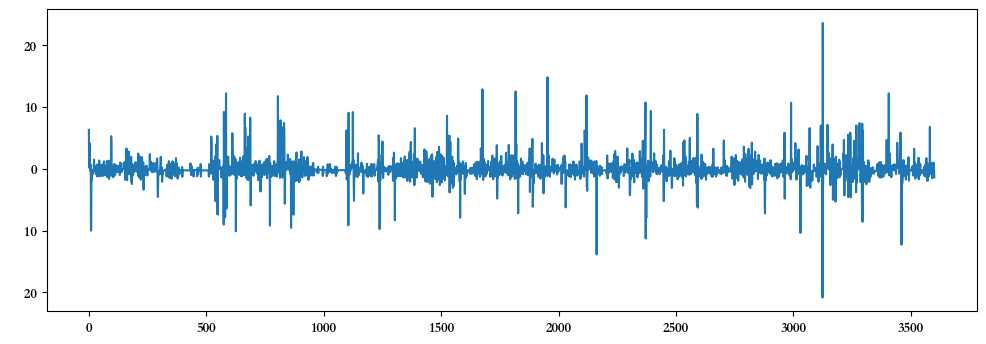

In [28]:
resid=best_model.resid  #残差
plt.figure(figsize=(12,4), dpi=100)
plt.plot(resid)
plt.show()

In [29]:
from scipy import stats 
print(stats.normaltest(resid))#检验序列残差是否为正态分布    pvalue<  0.05  拒绝原假设 认为残差符合正太分布

NormaltestResult(statistic=1290.0876441963037, pvalue=7.261518982379012e-281)


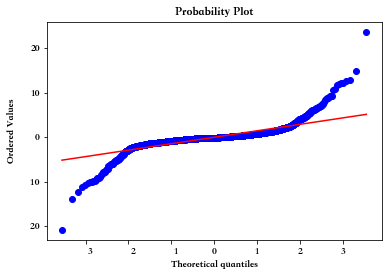

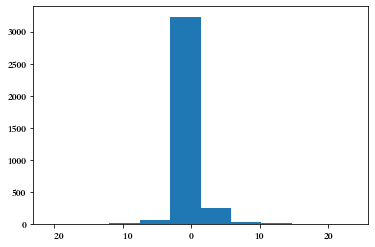

In [30]:
# p<0.05,接受备择假设，认为残差具有正态性
stats.probplot(resid, dist="norm", plot=plt)
plt.show()
plt.hist(resid,bins=10)
plt.show()

In [31]:
# qq图散点基本在直线上，同时直方图也呈现正态性。
from statsmodels.stats.stattools import durbin_watson
print("DW检验:", durbin_watson(best_model.resid))  ##DW检验：靠近2——正常；靠近0——正自相关；靠近4——负自相关

DW检验: 1.9969662097912548


In [32]:
# DW值靠近2，说明序列不具有相关性
# 打印模型训练和测试， 计算损失
from statsmodels.tsa.arima_model import ARIMA
from itertools import product
import tqdm
size=int(0.7*len(series)) # 70%训练，30%测试
train, test_arima = series[:size], series[size:len(series)]
history=[k for k in train]
predictions = list()
indexs1 = range(len(df.index[size:len(series)]))
c=0
for t in range(len(test_arima)-1):
    c+=1
    model = sm.tsa.arima.ARIMA(history, order=(3,0,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = int(output[0])#预测
    predictions.append(yhat)
    obs = test_arima[t]##真实值
    history.append(obs)
    print(f"all {len(test_arima)} No.{c} {indexs1[c-1]}==> predicted=%d, expected=%d"% (yhat, obs))
 

all 1081 No.1 0==> predicted=8, expected=9
all 1081 No.2 1==> predicted=9, expected=9
all 1081 No.3 2==> predicted=9, expected=10
all 1081 No.4 3==> predicted=10, expected=9
all 1081 No.5 4==> predicted=8, expected=8
all 1081 No.6 5==> predicted=8, expected=8
all 1081 No.7 6==> predicted=8, expected=7
all 1081 No.8 7==> predicted=7, expected=7
all 1081 No.9 8==> predicted=7, expected=8
all 1081 No.10 9==> predicted=8, expected=8
all 1081 No.11 10==> predicted=8, expected=6
all 1081 No.12 11==> predicted=5, expected=10
all 1081 No.13 12==> predicted=11, expected=15
all 1081 No.14 13==> predicted=15, expected=14
all 1081 No.15 14==> predicted=13, expected=14
all 1081 No.16 15==> predicted=13, expected=18
all 1081 No.17 16==> predicted=18, expected=22
all 1081 No.18 17==> predicted=22, expected=23
all 1081 No.19 18==> predicted=22, expected=22
all 1081 No.20 19==> predicted=21, expected=21
all 1081 No.21 20==> predicted=20, expected=23
all 1081 No.22 21==> predicted=22, expected=23
all 10

all 1081 No.177 176==> predicted=7, expected=7
all 1081 No.178 177==> predicted=7, expected=8
all 1081 No.179 178==> predicted=8, expected=7
all 1081 No.180 179==> predicted=7, expected=7
all 1081 No.181 180==> predicted=7, expected=7
all 1081 No.182 181==> predicted=7, expected=7
all 1081 No.183 182==> predicted=7, expected=7
all 1081 No.184 183==> predicted=7, expected=11
all 1081 No.185 184==> predicted=12, expected=16
all 1081 No.186 185==> predicted=16, expected=16
all 1081 No.187 186==> predicted=16, expected=17
all 1081 No.188 187==> predicted=16, expected=18
all 1081 No.189 188==> predicted=17, expected=18
all 1081 No.190 189==> predicted=17, expected=17
all 1081 No.191 190==> predicted=16, expected=17
all 1081 No.192 191==> predicted=16, expected=17
all 1081 No.193 192==> predicted=17, expected=18
all 1081 No.194 193==> predicted=18, expected=18
all 1081 No.195 194==> predicted=18, expected=17
all 1081 No.196 195==> predicted=17, expected=17
all 1081 No.197 196==> predicted=17

all 1081 No.345 344==> predicted=23, expected=23
all 1081 No.346 345==> predicted=22, expected=23
all 1081 No.347 346==> predicted=22, expected=23
all 1081 No.348 347==> predicted=22, expected=23
all 1081 No.349 348==> predicted=23, expected=24
all 1081 No.350 349==> predicted=23, expected=23
all 1081 No.351 350==> predicted=22, expected=22
all 1081 No.352 351==> predicted=22, expected=22
all 1081 No.353 352==> predicted=21, expected=22
all 1081 No.354 353==> predicted=21, expected=21
all 1081 No.355 354==> predicted=21, expected=22
all 1081 No.356 355==> predicted=21, expected=21
all 1081 No.357 356==> predicted=20, expected=19
all 1081 No.358 357==> predicted=18, expected=20
all 1081 No.359 358==> predicted=20, expected=14
all 1081 No.360 359==> predicted=13, expected=7
all 1081 No.361 360==> predicted=6, expected=7
all 1081 No.362 361==> predicted=7, expected=8
all 1081 No.363 362==> predicted=8, expected=7
all 1081 No.364 363==> predicted=7, expected=7
all 1081 No.365 364==> predic

all 1081 No.513 512==> predicted=14, expected=14
all 1081 No.514 513==> predicted=14, expected=14
all 1081 No.515 514==> predicted=14, expected=14
all 1081 No.516 515==> predicted=14, expected=15
all 1081 No.517 516==> predicted=15, expected=15
all 1081 No.518 517==> predicted=14, expected=15
all 1081 No.519 518==> predicted=15, expected=14
all 1081 No.520 519==> predicted=14, expected=14
all 1081 No.521 520==> predicted=13, expected=14
all 1081 No.522 521==> predicted=13, expected=14
all 1081 No.523 522==> predicted=13, expected=13
all 1081 No.524 523==> predicted=12, expected=13
all 1081 No.525 524==> predicted=13, expected=13
all 1081 No.526 525==> predicted=13, expected=14
all 1081 No.527 526==> predicted=14, expected=14
all 1081 No.528 527==> predicted=14, expected=13
all 1081 No.529 528==> predicted=13, expected=13
all 1081 No.530 529==> predicted=13, expected=13
all 1081 No.531 530==> predicted=13, expected=13
all 1081 No.532 531==> predicted=13, expected=13
all 1081 No.533 532=

all 1081 No.682 681==> predicted=15, expected=14
all 1081 No.683 682==> predicted=14, expected=14
all 1081 No.684 683==> predicted=14, expected=14
all 1081 No.685 684==> predicted=14, expected=14
all 1081 No.686 685==> predicted=14, expected=14
all 1081 No.687 686==> predicted=14, expected=14
all 1081 No.688 687==> predicted=14, expected=14
all 1081 No.689 688==> predicted=14, expected=14
all 1081 No.690 689==> predicted=14, expected=14
all 1081 No.691 690==> predicted=14, expected=14
all 1081 No.692 691==> predicted=14, expected=14
all 1081 No.693 692==> predicted=14, expected=14
all 1081 No.694 693==> predicted=14, expected=16
all 1081 No.695 694==> predicted=16, expected=18
all 1081 No.696 695==> predicted=17, expected=22
all 1081 No.697 696==> predicted=22, expected=22
all 1081 No.698 697==> predicted=21, expected=17
all 1081 No.699 698==> predicted=16, expected=18
all 1081 No.700 699==> predicted=17, expected=18
all 1081 No.701 700==> predicted=17, expected=17
all 1081 No.702 701=

all 1081 No.852 851==> predicted=6, expected=5
all 1081 No.853 852==> predicted=5, expected=5
all 1081 No.854 853==> predicted=5, expected=7
all 1081 No.855 854==> predicted=7, expected=6
all 1081 No.856 855==> predicted=6, expected=5
all 1081 No.857 856==> predicted=5, expected=5
all 1081 No.858 857==> predicted=5, expected=5
all 1081 No.859 858==> predicted=5, expected=6
all 1081 No.860 859==> predicted=6, expected=6
all 1081 No.861 860==> predicted=6, expected=6
all 1081 No.862 861==> predicted=6, expected=6
all 1081 No.863 862==> predicted=6, expected=6
all 1081 No.864 863==> predicted=6, expected=5
all 1081 No.865 864==> predicted=5, expected=5
all 1081 No.866 865==> predicted=5, expected=5
all 1081 No.867 866==> predicted=5, expected=5
all 1081 No.868 867==> predicted=5, expected=5
all 1081 No.869 868==> predicted=5, expected=6
all 1081 No.870 869==> predicted=6, expected=6
all 1081 No.871 870==> predicted=6, expected=6
all 1081 No.872 871==> predicted=6, expected=6
all 1081 No.8

all 1081 No.1021 1020==> predicted=10, expected=11
all 1081 No.1022 1021==> predicted=11, expected=11
all 1081 No.1023 1022==> predicted=11, expected=10
all 1081 No.1024 1023==> predicted=10, expected=10
all 1081 No.1025 1024==> predicted=10, expected=10
all 1081 No.1026 1025==> predicted=10, expected=9
all 1081 No.1027 1026==> predicted=9, expected=9
all 1081 No.1028 1027==> predicted=9, expected=9
all 1081 No.1029 1028==> predicted=9, expected=9
all 1081 No.1030 1029==> predicted=9, expected=9
all 1081 No.1031 1030==> predicted=9, expected=9
all 1081 No.1032 1031==> predicted=9, expected=9
all 1081 No.1033 1032==> predicted=9, expected=9
all 1081 No.1034 1033==> predicted=9, expected=9
all 1081 No.1035 1034==> predicted=9, expected=9
all 1081 No.1036 1035==> predicted=9, expected=9
all 1081 No.1037 1036==> predicted=9, expected=9
all 1081 No.1038 1037==> predicted=9, expected=10
all 1081 No.1039 1038==> predicted=10, expected=9
all 1081 No.1040 1039==> predicted=9, expected=9
all 108

In [33]:
# ARIMA模型的评价指标
arima_rmse = np.sqrt(mean_squared_error(test_arima[:-1], predictions))
arima_mae = mean_absolute_error(test_arima[:-1], predictions)

# 均方根误差、平均绝对误差
print("ARIMA 30min MAE:", arima_mae)
print("ARIMA 30min RMSE:", arima_rmse)

ARIMA 30min MAE: 1.0925925925925926
ARIMA 30min RMSE: 2.050406463769237


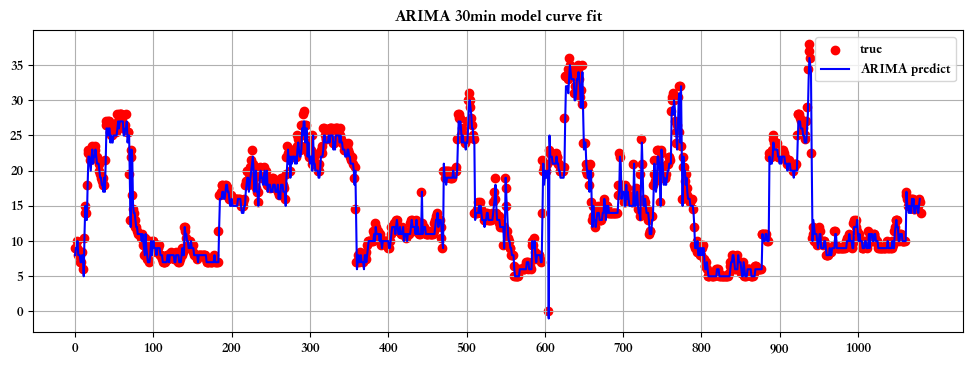

In [34]:
# 拟合情况
plt.figure(figsize = (12,4), dpi=100)
plt.scatter(range(len(indexs1)), test_arima, marker='o', label='true', c='red')
plt.plot(range(len(indexs1[:-1])), predictions, c='blue', label='ARIMA predict')
plt.legend()
plt.title("ARIMA 30min model curve fit")
plt.grid()
plt.xticks(np.arange(0, len(indexs1), 100))
plt.show() # 可见拟合得很好

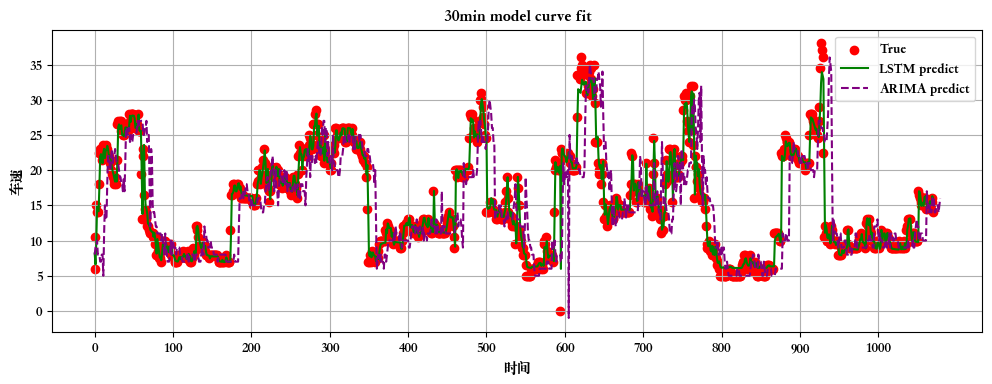

In [35]:
# 两个模型的拟合--在一张图上
# 拟合情况
plt.figure(figsize = (12,4), dpi=100)
plt.scatter(indexs, inverse_test, marker='o', label='True', c='red')
plt.plot(indexs, inverse_lstm_pred, c='green', label='LSTM predict')
plt.plot(indexs1[:-1],
         predictions, c='purple', label='ARIMA predict',
        linestyle='--')

plt.legend()
plt.title("30min model curve fit")
plt.xlabel("时间")
plt.ylabel("车速")
plt.grid()
plt.xticks(np.arange(0, len(indexs), 100))
plt.show() # 可见拟合得很好

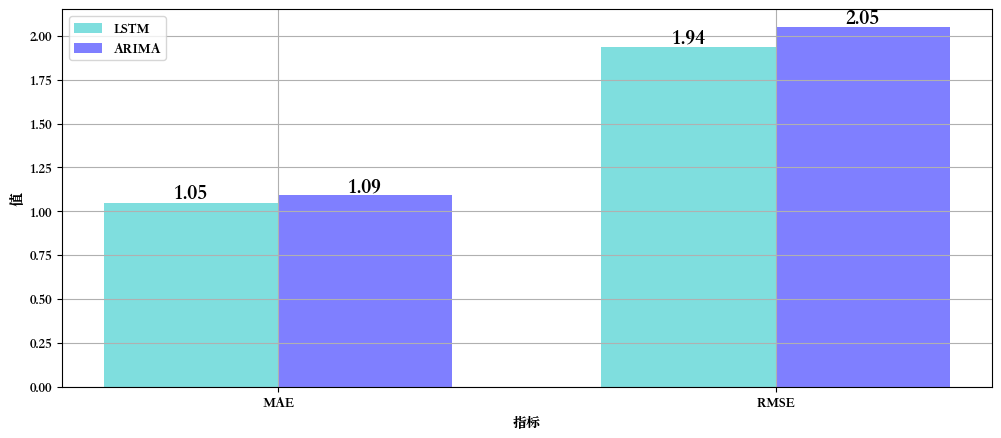

In [36]:
# 指标比较
plt.figure(figsize=(12,5),dpi=100)
xlabel = ['MAE','RMSE']
x=np.arange(len(xlabel))

y = [lstm_mae, lstm_rmse]
y1 = [arima_mae, arima_rmse]
bar_width = 0.35
rect1=plt.bar(x, y, bar_width, align="center", color="c", label="LSTM", alpha=0.5)
rect2=plt.bar(x+bar_width, y1, bar_width, color="b", align="center", label="ARIMA", alpha=0.5)
plt.xlabel("指标")
plt.ylabel("值")
plt.xticks(x+bar_width/2, xlabel)

for rect in rect1:  #rects 是三根柱子的集合
    height = round(rect.get_height(),2)
    plt.text(rect.get_x() + rect.get_width() / 2, height, str(height), size=15, ha='center', va='bottom')
for rect in rect2:  #rects 是三根柱子的集合
    height = round(rect.get_height(),2)
    plt.text(rect.get_x() + rect.get_width() / 2, height, str(height), size=15, ha='center', va='bottom')
plt.legend()
plt.grid()
plt.show()